# Turing Target Practice

## Model

In [1]:
] activate "."

  Activating project at `~/PhD/MicroCanonicalHMC.jl`


In [2]:
# The statistical inference frame-work we will use
using Turing
using Interpolations
using ForwardDiff
using LinearAlgebra
#using StatsPlots
using PyPlot
using Distributed

using Revise
using MicroCanonicalHMC

In [3]:
fs8_zs = [0.38, 0.51, 0.61, 1.48, 0.44, 0.6, 0.73, 0.6, 0.86, 0.067, 1.4]
fs8_data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482]
fs8_cov = [0.00203355 0.000811829 0.000264615 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.000811829 0.00142289 0.000662824 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 
           0.000264615 0.000662824 0.00118576 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.002025 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0064 0.00257 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.00257 0.003969 0.00254 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.00254 0.005184 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0144 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0121 0.0 0.0; 
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.003025 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.013456000000000001];

In [4]:
function make_fs8(Ωm, σ8; Ωr=8.24*10^-5)
    # ODE solution for growth factor
    x_Dz = LinRange(0, log(1+1100), 300)
    dx_Dz = x_Dz[2]-x_Dz[1]
    z_Dz = @.(exp(x_Dz) - 1)
    a_Dz = @.(1/(1+z_Dz))
    aa = reverse(a_Dz)
    e =  @.(sqrt.(abs(Ωm)*(1+z_Dz)^3+Ωr*(1+z_Dz)^4+(1-Ωm-Ωr)))
    ee = reverse(e)

    dd = zeros(typeof(Ωm), 300)
    yy = zeros(typeof(Ωm), 300)
    dd[1] = aa[1]
    yy[1] = aa[1]^3*ee[end]

    for i in 1:(300-1)
        A0 = -1.5 * Ωm / (aa[i]*ee[i])
        B0 = -1. / (aa[i]^2*ee[i])
        A1 = -1.5 * Ωm / (aa[i+1]*ee[i+1])
        B1 = -1. / (aa[i+1]^2*ee[i+1])
        yy[i+1] = (1+0.5*dx_Dz^2*A0*B0)*yy[i] + 0.5*(A0+A1)*dx_Dz*dd[i]
        dd[i+1] = 0.5*(B0+B1)*dx_Dz*yy[i] + (1+0.5*dx_Dz^2*A0*B0)*dd[i]
    end

    y = reverse(yy)
    d = reverse(dd)

    Dzi = LinearInterpolation(z_Dz, d./d[1], extrapolation_bc=Line())
    fs8zi = LinearInterpolation(z_Dz, -σ8 .* y./ (a_Dz.^2 .*e.*d[1]),
                                 extrapolation_bc=Line())
    return fs8zi
end

make_fs8 (generic function with 1 method)

In [5]:
@model function model(data; cov = fs8_cov) 
    # Define priors
    #KiDS priors
    Ωm ~ Uniform(0.2, 0.25)#~ Normal(0.3, 0.1)
    σ8 ~ Normal(0.8, 0.3)
    fs8_itp = make_fs8(Ωm, σ8)
    theory = fs8_itp(fs8_zs)
    data ~ MvNormal(theory, cov)
end;

In [6]:
stat_model = model(fs8_data)

DynamicPPL.Model{typeof(model), (:data, :cov), (:cov,), (), Tuple{Vector{Float64}, Matrix{Float64}}, Tuple{Matrix{Float64}}, DynamicPPL.DefaultContext}(model, (data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482], cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001]), (cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001],), DynamicPPL.DefaultContext())

## Sampling

In [7]:
target = TuringTarget(stat_model);

In [8]:
spl = MCHMC(0.0, 0.0, varE_wanted=2.0) #sqrt(target.d)*0.01

MicroCanonicalHMC.Sampler(Settings(Random.MersenneTwister(0), 2.0, 0, 1000, 10, "LF"), Hyperparameters{Float64}(0.0, 0.0, 0.0, 0.1931833275037836), MicroCanonicalHMC.Leapfrog)

In [75]:
spl.hyperparameters

Hyperparameters{Float64}(0.03125, 0.5544978032997125, 0.24424622763218604, 0.1931833275037836)

In [9]:
samples_mchmc = Sample(spl, target, 10000;
                       monitor_energy=true, 
                       dialog=true)

[ Info: Tuning eps ⏳


eps: 0.5 --> VarE: 374.86319425323757
eps: 0.25 --> VarE: 46.56221396534906
eps: 0.125 --> VarE: 21.067715444646364
eps: 0.0625 --> VarE: 4.407668334456997
eps: 0.03125 --> VarE: 1.2979107446053244


[ Info: Found eps: 0.03125 ✅
[ Info: Tuning L ⏳


samples: 100--> ESS: 0.02446809003659929
samples: 243--> ESS: 0.009299437760582839
samples: 447--> ESS: 0.022542920685374845


[ Info: Found L: 1.4142135623730951 ✅


10001-element Vector{Any}:
 [0.2438141528816781, 1.1746239742917952, 0.0, -22.637511631316038]
 [0.2438141528816781, 1.1746239742917952, 2.6859961587549464, -15.690441862898275]
 [0.24383667683758997, 1.1436523434807797, 15.938497261629717, -9.381937201584723]
 [0.24383474141448655, 1.1124043956056293, 18.204377503996675, -3.786226497031694]
 [0.24383233243577054, 1.0811575729384195, 16.058155956639016, 1.0965742239397738]
 [0.2438288894640535, 1.0499140582765376, 13.923320447449418, 5.266849358968842]
 [0.2438283007801406, 1.0186642477474146, 11.792023039338066, 8.72422001644643]
 [0.24382398952287104, 0.9874244045990709, 9.643239775098403, 11.467539925523337]
 [0.2438280295530934, 0.9561833231738333, 7.4950791677781226, 13.49782222348506]
 [0.24381584734040443, 0.9250144171934477, 5.360284943520391, 14.815630694134128]
 [0.2438260619367893, 0.893821393230874, 3.2304765587719686, 15.425785793237168]
 [0.2437938830998399, 0.8631397733232795, 1.1213487357100238, 15.335322371740041]
 [0.

In [10]:
#plt.plot(samples_mchmc.E[8000:end])

In [11]:
#mean(samples_mchmc.E[8000:end])

In [12]:
#std(samples_mchmc.E[8000:end])^2/target.d

In [13]:
Wms_mchmc = [sample[1] for sample in samples_mchmc]
s8s_mchmc = [sample[2] for sample in samples_mchmc];

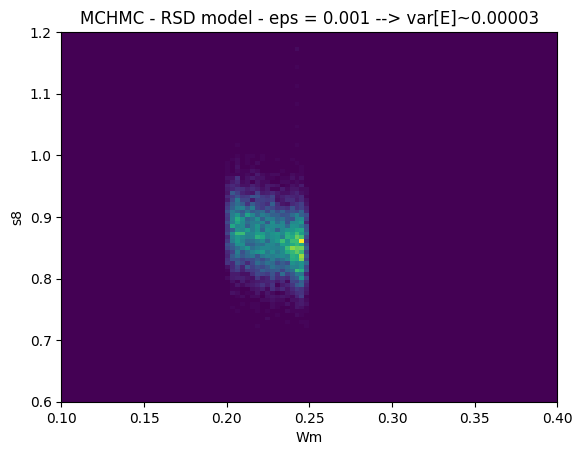

In [14]:
plt.hist2d(Wms_mchmc, s8s_mchmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("MCHMC - RSD model - eps = 0.001 --> var[E]~0.00003");

## AbstractMCMC

In [86]:
samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), 10000;
    monitor_energy=true, 
    dialog=true)

[ Info: Tuning eps ⏳


eps: 0.5 --> VarE: 41.23507165111667
eps: 0.25 --> VarE: NaN
eps: 0.125 --> VarE: 23.904500486269438
eps: 0.0625 --> VarE: 3.9449605494938287
eps: 0.03125 --> VarE: 1.057188898215027
samples: 100--> ESS: 0.02502017437566412
samples: 243--> ESS: 0.009259936236091691
samples: 447--> ESS: 0.02249763037449063


[ Info: Found eps: 0.03125 ✅
[ Info: Tuning L ⏳
[ Info: Found L: 1.4142135623730951 ✅
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (10000×4×1 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 0.99 seconds
Compute duration  = 0.99 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2225    0.0143     0.0001    0.0014     28.3335    1.1861    ⋯
          σ8    0.8675    0.0413     0.0004    0.0012   2705.2262    1.0126    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.2009    0.2097    0.2219    0.2339    0.2483
          σ8    0.7881    0.8394    0.8672    0.8947    0.9480


In [87]:
new_samples = sample(stat_model, MCHMC(varE_wanted=2.0), 10000; 
                     monitor_energy=true, 
                     progress=true, resume_from=samples)

[ Info: Starting from previous run
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (10000×4×1 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 0.96 seconds
Compute duration  = 0.96 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2260    0.0124     0.0001    0.0012     43.4648    1.0357    ⋯
          σ8    0.8650    0.0396     0.0004    0.0009   2901.9526    1.0017    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.2046    0.2161    0.2260    0.2360    0.2478
          σ8    0.7872    0.8383    0.8644    0.8921    0.9435


In [ ]:
#StatsPlots.plot(new_samples)

## NUTS

In [ ]:
samples_hmc = sample(stat_model, NUTS(500, 0.65),
                     10000, progress=true; save_state=true)

In [ ]:
samples_hmc.value

In [ ]:
Wms_hmc = vec(samples_hmc["Ωm"])
s8s_hmc = vec(samples_hmc["σ8"]);

In [ ]:
plt.hist2d(Wms_hmc, s8s_hmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("HMC - RSD model");